In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap

# Define a cleaning function for the dataset
def clean_fire_data(df):
    # Drop rows where essential columns like 'YEAR_' or 'GIS_ACRES' are missing
    df = df.dropna(subset=['YEAR_', 'GIS_ACRES'])
    
    # Convert 'YEAR_' to integer for easier analysis
    df.loc[:, 'YEAR_'] = df['YEAR_'].astype(int)  # Fixed SettingWithCopyWarning

    # Convert date columns to datetime for better handling
    for date_col in ['ALARM_DATE', 'CONT_DATE']:
        df.loc[:, date_col] = pd.to_datetime(df[date_col], errors='coerce')  # Fixed SettingWithCopyWarning
    
    # Drop columns with excessive missing data or limited utility
    columns_to_drop = ['COMMENTS', 'COMPLEX_NAME', 'IRWINID', 'COMPLEX_ID', 'FIRE_NUM']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])  # Avoid errors if columns don't exist

    # Fill missing 'AGENCY', 'UNIT_ID', and 'FIRE_NAME' with placeholder text
    df.loc[:, 'AGENCY'] = df['AGENCY'].fillna('Unknown')
    df.loc[:, 'UNIT_ID'] = df['UNIT_ID'].fillna('Unknown')
    df.loc[:, 'FIRE_NAME'] = df['FIRE_NAME'].fillna('Unnamed Fire')

    # Ensure other categorical columns have consistent formatting (e.g., string types)
    df.loc[:, 'STATE'] = df['STATE'].astype(str)

    return df

# Load the dataset
file_path = './Resources/California_Fire_Perimeters_(all).csv'
fire_data = pd.read_csv(file_path)

# Clean the dataset
cleaned_fire_data = clean_fire_data(fire_data)

# Save cleaned data to CSV file
cleaned_fire_data.to_csv("Resources/cleaned_fire_data.csv", index=False)

print("✅ Cleaned data successfully saved!")



✅ Cleaned data successfully saved!


In [12]:
import numpy as np
import pandas as pd

# Ensure ALARM_DATE and CONT_DATE are in datetime format
cleaned_fire_data['ALARM_DATE'] = pd.to_datetime(cleaned_fire_data['ALARM_DATE'], errors='coerce')
cleaned_fire_data['CONT_DATE'] = pd.to_datetime(cleaned_fire_data['CONT_DATE'], errors='coerce')

# Drop rows where ALARM_DATE or CONT_DATE are missing after conversion
cleaned_fire_data = cleaned_fire_data.dropna(subset=['ALARM_DATE', 'CONT_DATE'])

# Calculate containment duration in hours
cleaned_fire_data['Containment_Duration'] = (
    (cleaned_fire_data['CONT_DATE'] - cleaned_fire_data['ALARM_DATE']).dt.total_seconds() / 3600
)

# Remove invalid containment durations (zero or negative)
cleaned_fire_data = cleaned_fire_data[cleaned_fire_data['Containment_Duration'] > 0]

# Calculate effectiveness (handling divide-by-zero issues)
cleaned_fire_data['Effectiveness'] = cleaned_fire_data['GIS_ACRES'] / cleaned_fire_data['Containment_Duration']

# Replace infinite and negative infinite values with NaN
cleaned_fire_data['Effectiveness'].replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows where Effectiveness is NaN after calculations
cleaned_fire_data = cleaned_fire_data.dropna(subset=['Effectiveness'])

# Ensure C_METHOD is not missing before grouping
cleaned_fire_data = cleaned_fire_data.dropna(subset=['C_METHOD'])

# Group by containment method and calculate mean effectiveness
method_effectiveness = cleaned_fire_data.groupby('C_METHOD').agg(
    Average_Effectiveness=('Effectiveness', 'mean'),
    Count=('Effectiveness', 'count')
).sort_values(by='Average_Effectiveness', ascending=False)

# Display the results
print(method_effectiveness)



          Average_Effectiveness  Count
C_METHOD                              
3.0                   22.065185    225
7.0                   21.092517    663
2.0                   20.532006    454
8.0                   16.594689   1836
5.0                   14.559857     49
6.0                   11.021989    438
4.0                    9.448320     92
1.0                    5.077024   1759


C:\Users\ntrie\AppData\Local\Temp\ipykernel_6256\4194350121.py:23: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cleaned_fire_data['Effectiveness'].replace([np.inf, -np.inf], np.nan, inplace=True)


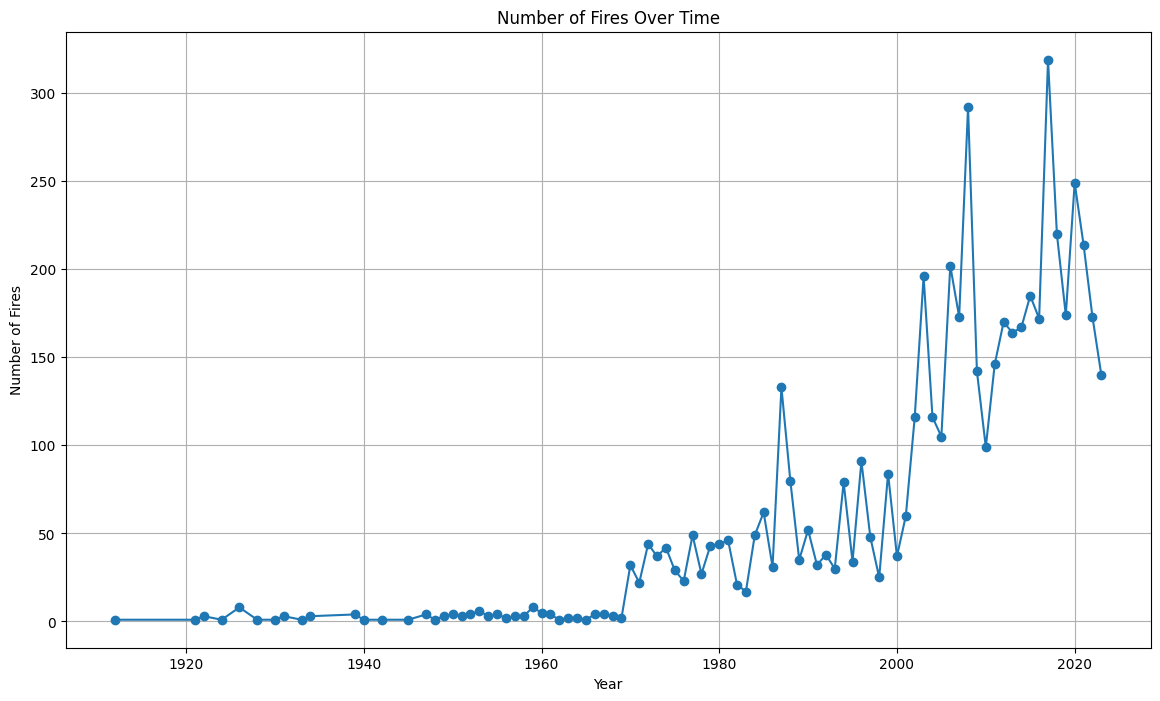

Peak Years for Fires:
YEAR_
2017.0    319
2008.0    292
2020.0    249
2018.0    220
2021.0    214
dtype: int64


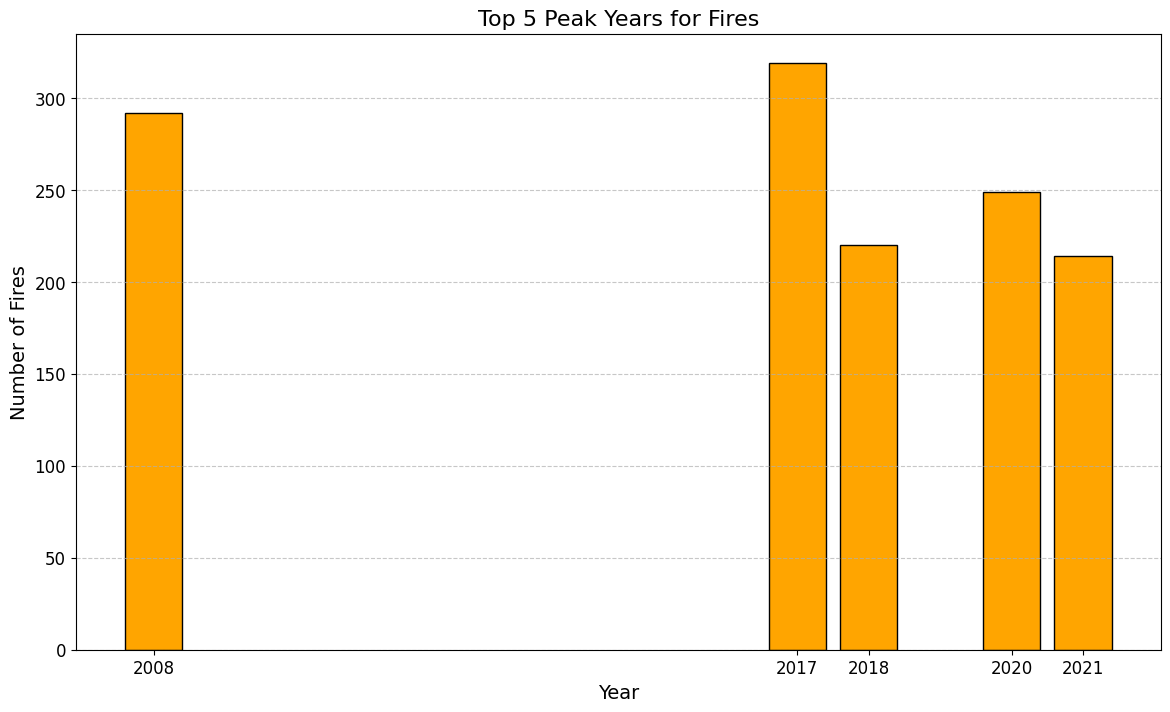

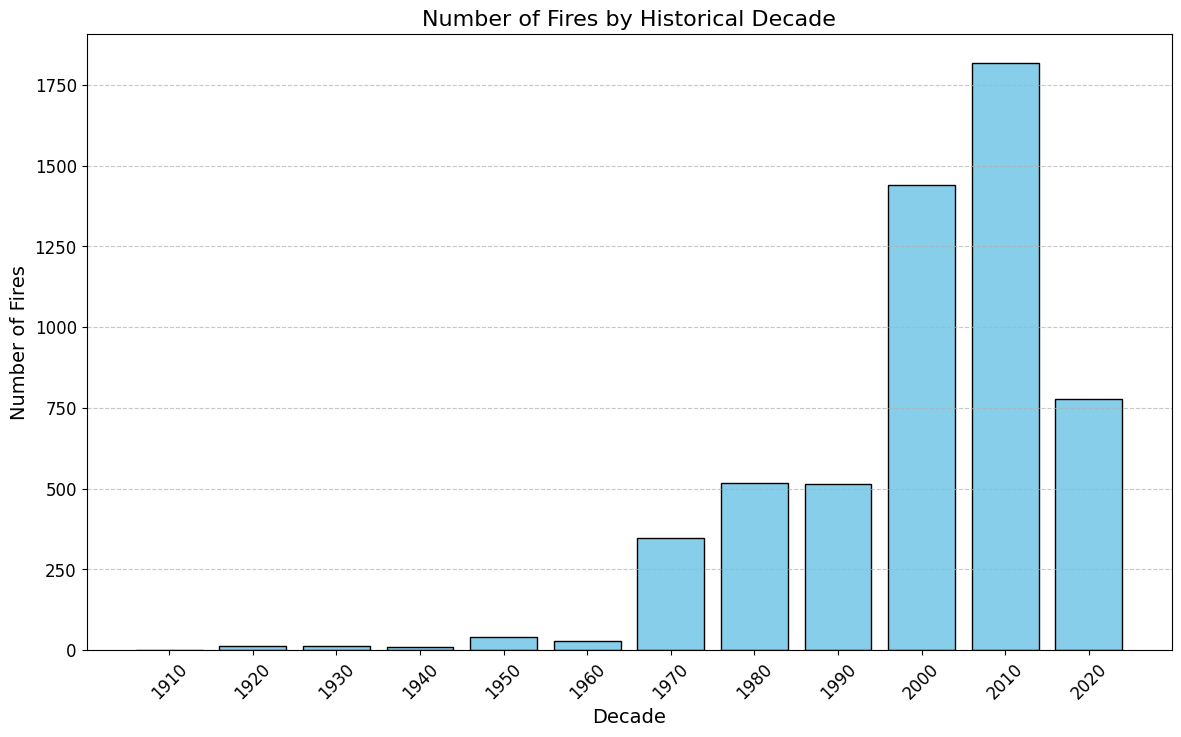

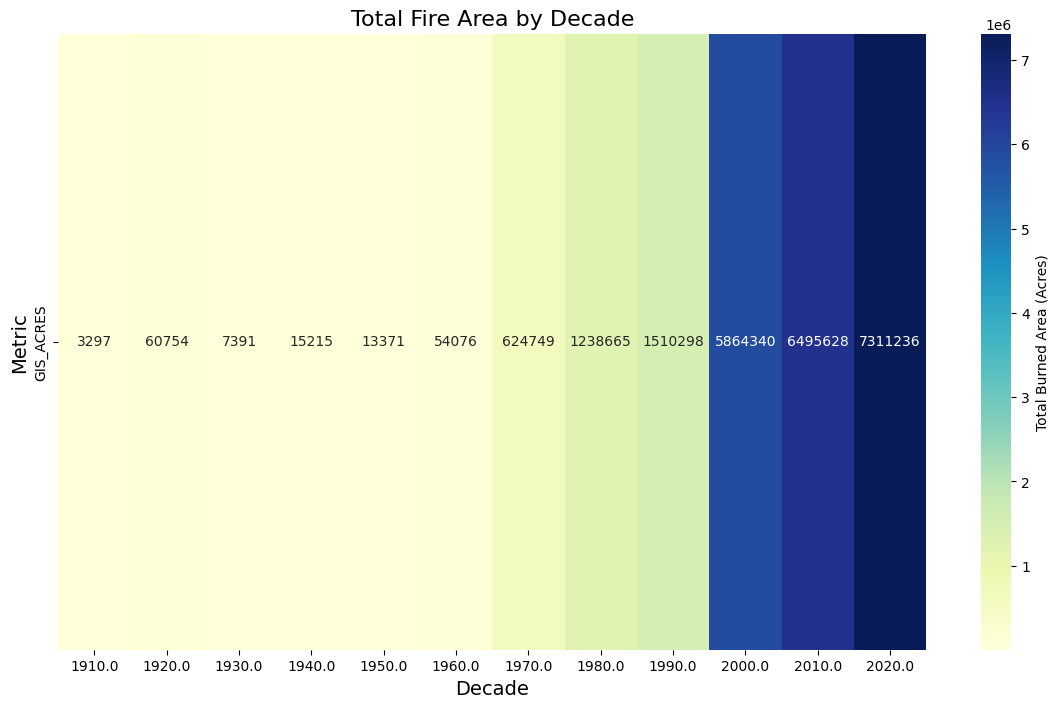

<class 'pandas.core.frame.DataFrame'>
Index: 5516 entries, 2 to 21833
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   OBJECTID              5516 non-null   int64              
 1   YEAR_                 5516 non-null   float64            
 2   STATE                 5516 non-null   object             
 3   AGENCY                5516 non-null   object             
 4   UNIT_ID               5516 non-null   object             
 5   FIRE_NAME             5516 non-null   object             
 6   INC_NUM               5196 non-null   object             
 7   ALARM_DATE            5516 non-null   datetime64[ns, UTC]
 8   CONT_DATE             5516 non-null   datetime64[ns, UTC]
 9   CAUSE                 5516 non-null   float64            
 10  C_METHOD              5516 non-null   float64            
 11  OBJECTIVE             5399 non-null   float64            
 12  GIS_ACRES 

In [13]:
# Plot the number of fires over time
fires_per_year = cleaned_fire_data.groupby('YEAR_').size()
plt.figure(figsize=(14, 8))
plt.plot(fires_per_year.index, fires_per_year.values, marker='o')
plt.title('Number of Fires Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Fires')
plt.grid(True)
plt.savefig('./Resources/fires_over_time.png')
plt.show()

# Identify peak years for fires
peak_years = fires_per_year.sort_values(ascending=False).head(5)
print("Peak Years for Fires:")
print(peak_years)

# Plot the peak years for fires
peak_years_sorted = peak_years.sort_index()
plt.figure(figsize=(14, 8))
plt.bar(peak_years_sorted.index, peak_years_sorted.values, color='orange', edgecolor='black')
plt.title('Top 5 Peak Years for Fires', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Number of Fires', fontsize=14)
plt.xticks(peak_years_sorted.index, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('./Resources/peak_years_for_fires.png')
plt.show()

# Plot the number of fires by decade
cleaned_fire_data['Decade'] = (cleaned_fire_data['YEAR_'] // 10) * 10
fires_by_decade = cleaned_fire_data.groupby('Decade').size()
plt.figure(figsize=(14, 8))
plt.bar(fires_by_decade.index, fires_by_decade.values, color='skyblue', edgecolor='black', width=8)
plt.title('Number of Fires by Historical Decade', fontsize=16)
plt.xlabel('Decade', fontsize=14)
plt.ylabel('Number of Fires', fontsize=14)
plt.xticks(fires_by_decade.index, fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig('./Resources/fires_by_decade.png')
plt.show()

# Heatmap: Total fire area by decade
fire_area_by_decade = cleaned_fire_data.groupby('Decade')['GIS_ACRES'].sum().reset_index()
plt.figure(figsize=(14, 8))
sns.heatmap(fire_area_by_decade.set_index('Decade').T, annot=True, fmt='.0f', cmap='YlGnBu', cbar_kws={'label': 'Total Burned Area (Acres)'})
plt.title('Total Fire Area by Decade', fontsize=16)
plt.xlabel('Decade', fontsize=14)
plt.ylabel('Metric', fontsize=14)
plt.savefig('./Resources/fire_area_by_decade.png')
plt.show()

# Display basic information
print(cleaned_fire_data.info())
print(cleaned_fire_data.head())




In [ ]:
# Cause data analysis
if 'CAUSE' in cleaned_fire_data.columns:
    cause_counts = cleaned_fire_data['CAUSE'].value_counts()
    print("Cause Data Analysis:")
    print(cause_counts)
else:
    print("Cause column is missing in the dataset.")

# Display basic information
print(cleaned_fire_data.info())
print(cleaned_fire_data.head())

Cause Data Analysis:
CAUSE
14.0    9908
1.0     3516
9.0     3470
2.0     1349
7.0      954
5.0      764
10.0     558
11.0     454
4.0      397
3.0      339
8.0      192
18.0     103
6.0       79
15.0      29
19.0      17
16.0      15
13.0      11
12.0       5
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 22184 entries, 0 to 22183
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype              
---  ------                --------------  -----              
 0   OBJECTID              22184 non-null  int64              
 1   YEAR_                 22184 non-null  int32              
 2   STATE                 22184 non-null  object             
 3   AGENCY                22184 non-null  object             
 4   UNIT_ID               22184 non-null  object             
 5   FIRE_NAME             22184 non-null  object             
 6   INC_NUM               21281 non-null  object             
 7   ALARM_DATE            16865 non-null 

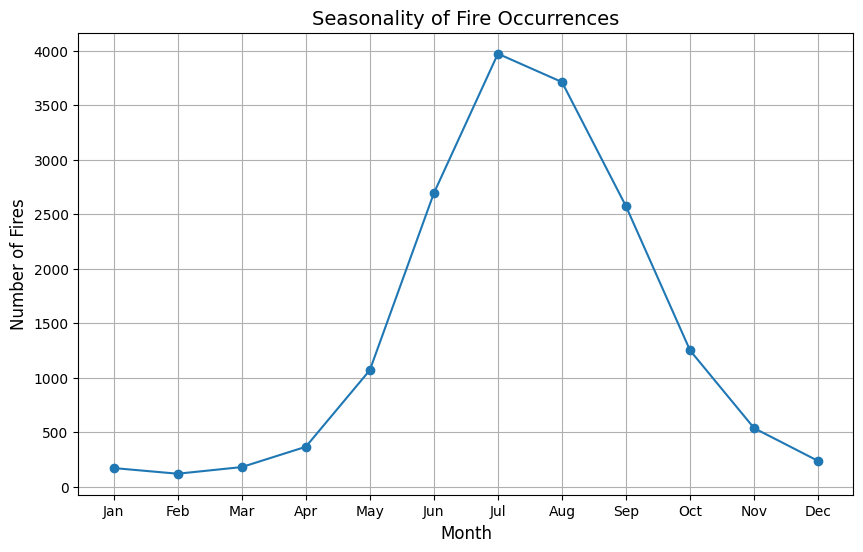

In [ ]:
# Extract the month from the ALARM_DATE column
cleaned_fire_data['Month'] = cleaned_fire_data['ALARM_DATE'].dt.month

# Group by month and count the number of fires
fires_by_month = cleaned_fire_data.groupby('Month').size()

# Plot the seasonality
plt.figure(figsize=(10, 6))
plt.plot(fires_by_month.index, fires_by_month.values, marker='o')
plt.title('Seasonality of Fire Occurrences', fontsize=14)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Fires', fontsize=12)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.savefig('./Resources/seasonality.png')
plt.show()
